In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [8]:
df = pd.read_pickle('inference/pred_M1_B2.pkl')
df.shape

(32953924, 4)

In [7]:
df.describe()

,direction_x,direction_y,direction_z,direction_kappa
count,3.295392e+07,3.295392e+07,3.295392e+07,3.295392e+07
mean,8.382690e-03,-2.198419e-02,2.888406e-01,1.877204e+01
std,5.085194e-01,5.110986e-01,6.294466e-01,5.035062e+01
min,-1.000000e+00,-9.999999e-01,-1.000000e+00,7.527557e-04
25%,-3.664360e-01,-4.046652e-01,-1.683968e-01,2.518829e-01
50%,1.007504e-02,-2.417513e-02,4.639624e-01,6.876704e-01
75%,3.869625e-01,3.495848e-01,8.473178e-01,4.398259e+00
max,9.999999e-01,9.999998e-01,1.000000e+00,7.941101e+03


In [9]:
df.describe()


,direction_x,direction_y,direction_z,direction_kappa
count,3.295392e+07,3.295392e+07,3.295392e+07,3.295392e+07
mean,2.032444e-02,-3.302985e-03,3.227282e-01,1.827732e+01
std,5.087141e-01,5.110665e-01,6.127339e-01,4.055118e+01
min,-9.999996e-01,-9.999994e-01,-1.000000e+00,4.689540e-04
25%,-3.565305e-01,-3.850754e-01,-9.864769e-02,2.512404e-01
50%,2.391068e-02,-4.918493e-03,5.060209e-01,6.700859e-01
75%,4.043942e-01,3.769416e-01,8.556113e-01,4.474530e+00
max,9.999999e-01,9.999999e-01,1.000000e+00,2.589464e+03


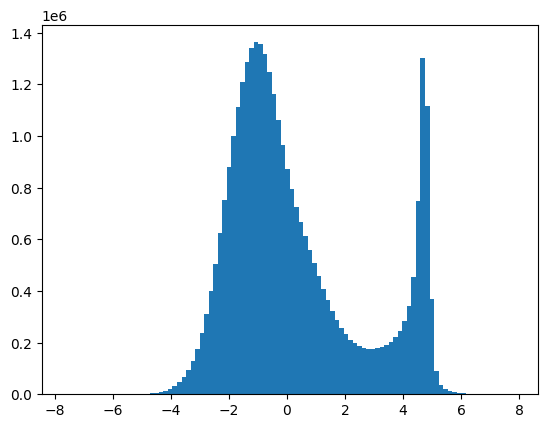

In [5]:
# plot the distribution of the direction_kappa using matplotlib
plt.hist(np.log(df['direction_kappa']), bins=100)
plt.show()

In [24]:
df[np.log(df.direction_kappa) > 3].direction_kappa.min()

20.085594177246094